# <a id='toc1_'></a>[UCRB Streamflow Sandbox](#toc0_)
Author: Daniel Hogan

Creation Date: 2023-04-25

This notebook explores the general trends in streamflow, precipitation, and temperature across the UCRB.
Figure 1 from the publication is created within, along with figures in the SI Appendix. See table of contents to get main ideas.

**Note: Links in the TOC will not work in GitHub**

**Table of contents**<a id='toc0_'></a>    
- [UCRB Streamflow Sandbox](#toc1_)    
    - [Import Packages](#toc1_1_1_)    
- [Import UCRB PRISM temperature and precipitation data](#toc2_)    
    - [Temperature](#toc2_1_1_)    
    - [Precipitation](#toc2_1_2_)    
- [Import naturalized streamflow](#toc3_)    
- [Plot Precipitation, Streamflow and Temperature all together](#toc4_)    
    - [Plot streamflow and precipitation standardized anomalies](#toc4_1_1_)    
    - [Figure 1 A Plot within Manuscript](#toc4_1_2_)    
    - [Streamflow, Precipitation, Temperature Figure used in Supplemental Text](#toc4_1_3_)    
- [Let's change to focusing on our HCDN basins](#toc5_)    
- [Cumulative Streamflow Deficit Plots](#toc6_)    
    - [Quick Statistical test for a single site](#toc6_1_1_)    
    - [Double Mass Plots](#toc6_1_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

### <a id='toc1_1_1_'></a>[Import Packages](#toc0_)

In [1]:
import geopandas as gpd
import rioxarray as rxr
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import pandas as pd
import scipy.stats as stats
import numpy as np
import datetime as dt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib as mpl

# <a id='toc2_'></a>[Import UCRB PRISM temperature and precipitation data](#toc0_)

In [2]:
#EPSG code
co_epsg = 32613

# pull in UCRB basin 
ucrb_basin_boundary = gpd.read_file('../basin_characteristics/Upper_Colorado_River_Basin_Boundary.json')
ucrb_basin_boundary = ucrb_basin_boundary.to_crs(co_epsg)

Check if a specific directory (../data/etdata/prism_tmean_normals) exists. If the directory does not exist, it proceeds to retrieve PRISM temperature data, reprojects and clips it based on specified parameters, and saves the result to a NetCDF file (../data/etdata/prism_tmean_normals.nc). If the directory already exists, it loads the temperature data from the existing NetCDF file instead.

PRISM data was downloaded from https://prism.oregonstate.edu/historical/. Filtered and saved data are available at the zenodo site referenced in the repository README.

### <a id='toc2_1_1_'></a>[Temperature](#toc0_)

Save PRISM climatological normals between 1990-2020

In [3]:
if not os.path.exists('../data/etdata/prism_tmean_normals'):
    # pull in PRISM data
    outpath = '../data/etdata/PRISM_tmean_30yr_normal_800mM4_annual_bil/'
    prism_tmean_normal = rxr.open_rasterio(outpath + 'PRISM_tmean_30yr_normal_800mM4_annual_bil.bil', masked=True)
    ucrb_prism_tmean_normal = prism_tmean_normal.rio.reproject(co_epsg).rio.clip(ucrb_basin_boundary.geometry).squeeze()
    # save to file
    ucrb_prism_tmean_normal.to_netcdf('../data/etdata/prism_tmean_normals.nc')
else:
    ucrb_prism_tmean_normal = xr.open_dataset('../data/etdata/prism_tmean_normals.nc')

Save PRISM temperature between 1895 and 2022 (whole time series)

In [ ]:
if not os.path.exists('../data/etdata/prism_tmean_4km_ucrb.nc'):
       # Download PRISM precipitation from 4km product 
       outpath = '/storage/dlhogan/sos/data/PRISM/'
       files = [x for x in os.listdir(outpath) if (x[-3:] == 'bil') and (len(x) == 39)]
       prism_list = []
       dates = []
       for file in files:
              dates.append(file[-14:-8]+'01')
              tmp = rxr.open_rasterio(os.path.join(outpath,file)).rio.reproject(co_epsg).rio.clip(ucrb_basin_boundary.geometry)
              prism_list.append(tmp)
       prism_4km_tmean_ds = xr.concat(prism_list, dim='band')
       prism_4km_tmean_ds = prism_4km_tmean_ds.rename({'band':'month'})

       # Assign dates to coordinates
       prism_4km_tmean_ds = prism_4km_tmean_ds.assign_coords({
              'month': pd.to_datetime(dates,format='%Y%m%d')}) 

       # Filter to correct dates
       prism_4km_tmean_ds = prism_4km_tmean_ds.sortby('month')
       prism_4km_tmean_ds = prism_4km_tmean_ds.sel(month=slice('1895-01-01', '2022-09-01'))

       prism_4km_tmean_ds.to_netcdf('../data/etdata/prism_tmean_4km_ucrb.nc')
else:
       prism_4km_tmean_ds = xr.open_dataset('../data/etdata/prism_tmean_4km_ucrb.nc')

### <a id='toc2_1_2_'></a>[Precipitation](#toc0_)

First download 1981 to 2022 data and add it to a netcdf

In [4]:
if not os.path.exists('../data/precipdata/prism_4km_ucrb.nc'):
       # Download PRISM precipitation from 4km product 
       outpath = '../data/precipdata/PRISM/PRISM_ppt_stable_4km/'
       files = [x for x in os.listdir(outpath) if (x[-3:] == 'bil') and (len(x) == 37)]
       prism_list = []
       dates = []
       for file in files:
              dates.append(file[-14:-8]+'01')
              tmp = rxr.open_rasterio(os.path.join(outpath,file)).rio.reproject(co_epsg).rio.clip(ucrb_basin_boundary.geometry)
              prism_list.append(tmp)
       prism_4km_ds = xr.concat(prism_list, dim='band', join='override')
       prism_4km_ds = prism_4km_ds.rename({'band':'month'})

       # Assign dates to coordinates
       prism_4km_ds = prism_4km_ds.assign_coords({
              'month': pd.to_datetime(dates,format='%Y%m%d')}) 

       # Filter to correct dates between 1981 and 2022
       prism_4km_ds = prism_4km_ds.sortby('month')
       prism_4km_ds = prism_4km_ds.sel(month=slice('1981-01-01', '2022-09-01'))

Add historical data from 1964 to present

In [ ]:
# Download historic PRISM precipitation from 4km product 
# this otupath should contain historical prism data 
outpath = '/storage/dlhogan/sos/data/PRISM_ppt/'
if not os.path.exists('../data/precipdata/prism_4km_ucrb.nc'):
       # get file name list
       files = [x for x in os.listdir(outpath) if (x[-3:] == 'bil') and (len(x) == 37)]
       prism_list = []
       dates = []
       # Open each file and append to a list
       for file in files:
              dates.append(file[-14:-8]+'01')
              tmp = rxr.open_rasterio(os.path.join(outpath,file)).rio.reproject(co_epsg).rio.clip(ucrb_basin_boundary.geometry)
              prism_list.append(tmp)
       # concatentate each file to netcdf
       prism_4km_historic_ds = xr.concat(prism_list, dim='band')
       prism_4km_historic_ds = prism_4km_historic_ds.rename({'band':'month'})

       # Assign dates to coordinates
       prism_4km_historic_ds = prism_4km_historic_ds.assign_coords({
              'month': pd.to_datetime(dates,format='%Y%m%d')}) 
       prism_4km_historic_ds = prism_4km_historic_ds.sortby('month')
       prism_4km_all_ds = xr.concat([prism_4km_historic_ds, prism_4km_ds], dim='month', join='override')
       prism_4km_all_ds.to_netcdf('../data/precipdata/prism_4km_ucrb.nc')
else:
       prism_4km_all_ds = xr.open_dataset('../data/precipdata/prism_4km_ucrb.nc')
       prism_4km_all_ds = prism_4km_all_ds.rename({'__xarray_dataarray_variable__':'ppt'})

# <a id='toc3_'></a>[Import naturalized streamflow](#toc0_)

Naturalized streamflow data downloaded from https://www.usbr.gov/lc/region/g4000/NaturalFlow/provisional.html

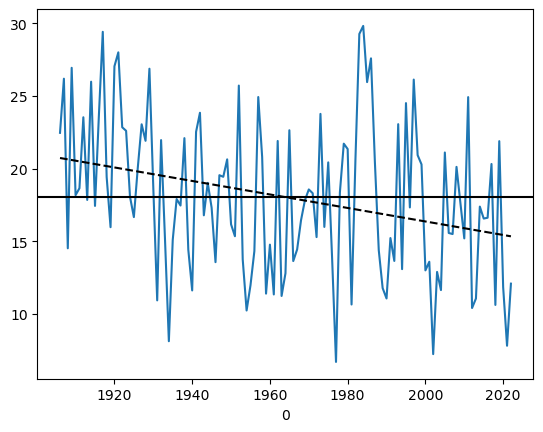

In [7]:
ucrb_naturalized_streamflow = pd.read_csv('../data/streamflowdata/LF_NATURALIZED_FLOW.csv', header=None, index_col=0)
ucrb_naturalized_streamflow = ucrb_naturalized_streamflow.rename(columns={1:'annual_flow_km3'}) * 1.23348e-6
ucrb_naturalized_streamflow['q_mm_day'] = ucrb_naturalized_streamflow['annual_flow_km3'] * 1e9 / 365 /ucrb_basin_boundary.area.values[0] * 1000
ucrb_naturalized_streamflow['annual_flow_anom'] = (ucrb_naturalized_streamflow['annual_flow_km3']-ucrb_naturalized_streamflow['annual_flow_km3'].mean())/ucrb_naturalized_streamflow['annual_flow_km3'].std()
slope1, intercept1, _,_,_ = stats.linregress(ucrb_naturalized_streamflow.index,ucrb_naturalized_streamflow['annual_flow_km3'].values)
ucrb_naturalized_streamflow['annual_flow_km3'].plot()
plt.plot(ucrb_naturalized_streamflow.index , slope1*ucrb_naturalized_streamflow.index + intercept1, ls='--',color='k')
plt.axhline(ucrb_naturalized_streamflow['annual_flow_km3'].mean(), color='k')

Calculate annual precipitation for each water year and convert to cubic kilometers

In [8]:
p_mean = prism_4km_all_ds.where(prism_4km_all_ds>0).mean(dim=['x','y'])
p_mean['WY'] = p_mean.month.dt.year.where(p_mean.month.dt.month<10, p_mean.month.dt.year+1)
annual_p_sum = p_mean.groupby('WY').sum()
annual_p_km3 = (annual_p_sum / 1000) * np.full(len(annual_p_sum.WY), ucrb_basin_boundary.area) / 1e9
annual_p_km3 = annual_p_km3.sel(WY=slice(1896,2022))
annual_p_km3 = annual_p_km3.rename({'ppt':'p_km3'})

Quick plot of precipitation trend over time. Note the limited trend

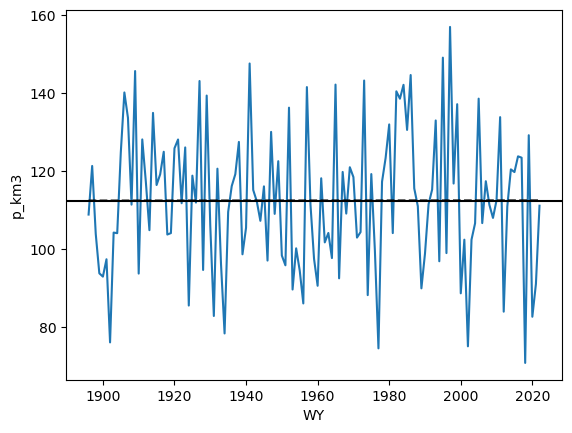

In [9]:
slope2, intercept2, _,_,_ = stats.linregress(annual_p_km3.WY,annual_p_km3['p_km3'].values)
annual_p_km3['p_km3'].plot()
plt.plot(annual_p_km3.WY , slope2*annual_p_km3.WY + intercept2, ls='--',color='k')
plt.axhline(annual_p_km3['p_km3'].mean(), color='k')

Calculate mean annual temperture for each water year

In [10]:
t_mean = prism_4km_tmean_ds.where(prism_4km_tmean_ds>-100).mean(dim=['x','y'])
t_mean['WY'] = t_mean.month.dt.year.where(t_mean.month.dt.month<10, t_mean.month.dt.year+1)
annual_t_mean = t_mean.groupby('WY').mean()
annual_t_mean = annual_t_mean.rename({'__xarray_dataarray_variable__':'t_mean'})
annual_t_mean = annual_t_mean.sel(WY=slice(1896,2022))


Quick plot of trend, note the increasing temperature with time

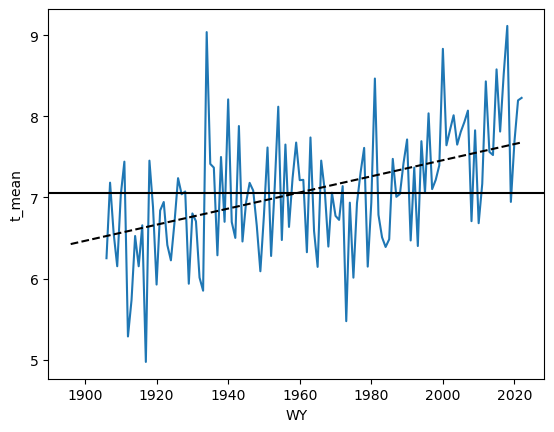

In [11]:
slope3, intercept3, _,_,_ = stats.linregress(annual_t_mean.WY,annual_t_mean['t_mean'].values)
annual_t_mean['t_mean'].sel(WY=slice(1906,2022)).plot()
plt.plot(annual_t_mean.WY , slope3*annual_t_mean.WY + intercept3, ls='--',color='k')
plt.axhline(annual_t_mean['t_mean'].mean(), color='k')

# <a id='toc4_'></a>[Plot Precipitation, Streamflow and Temperature all together](#toc0_)

In [12]:
# convert ucrb index to datetime and add month=1 and day=1
ucrb_naturalized_streamflow.index = pd.to_datetime([dt.datetime(x,1,1) for x in ucrb_naturalized_streamflow.index])

In [13]:
# Create a copy to be used in plotting the x-axis
ucrb_naturalized_streamflow_tmp = ucrb_naturalized_streamflow.copy()
ucrb_naturalized_streamflow_tmp.index = ucrb_naturalized_streamflow.index.year

Plot created for visualization of Millennium Drought and Baseline periods

(-23376.0, 18993.0)

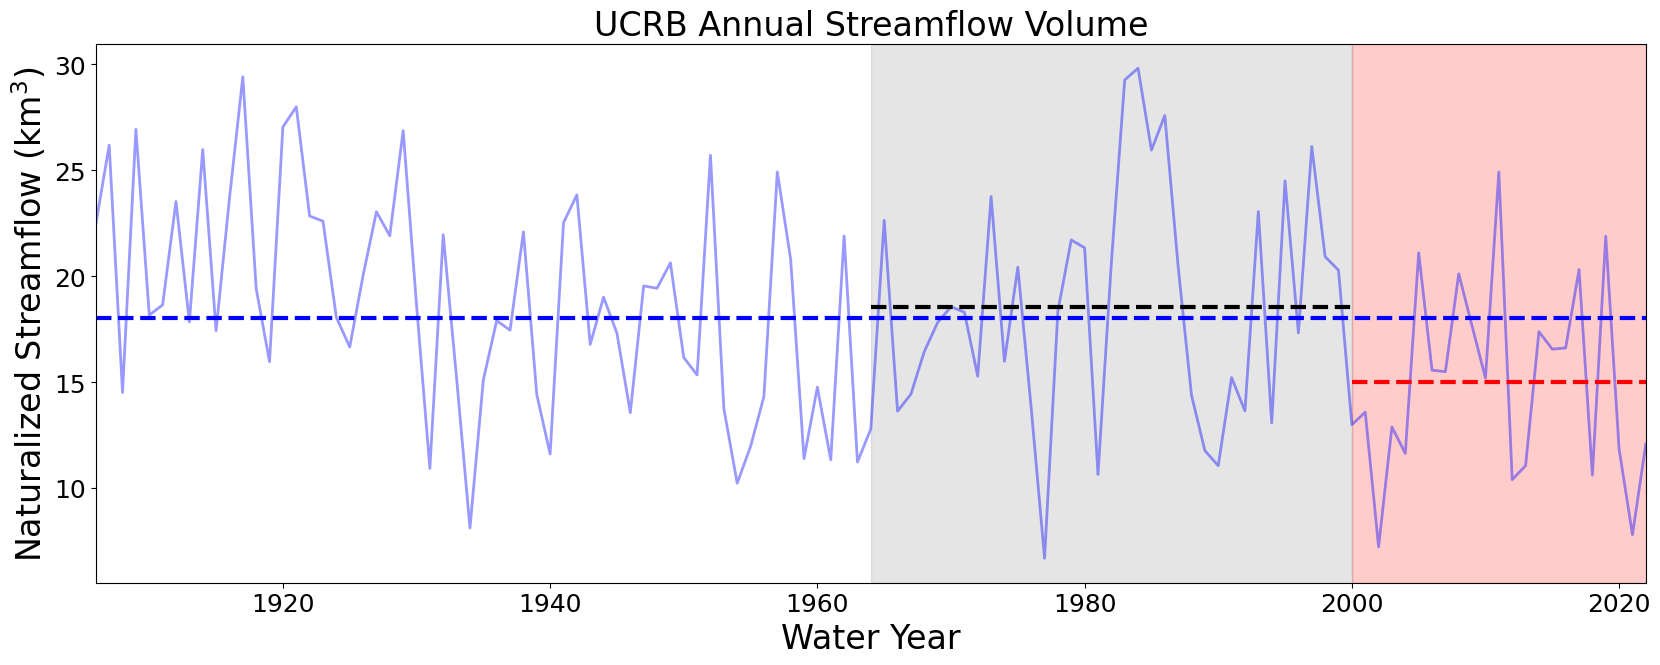

In [157]:
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(ucrb_naturalized_streamflow.index, 
        ucrb_naturalized_streamflow['annual_flow_km3'], 
        color='b', 
        alpha=0.4,
        lw=2)
####### RECORD #######
# plot the mean between 1906 and 2022
ax.axhline(ucrb_naturalized_streamflow['annual_flow_km3'].loc['1906':'2022'].mean(), color='b', lw=3,ls='--')
# add label above the line on the far left of the plot 1906-1999 mean
ax.text(dt.datetime(1920,1,1), 
        ucrb_naturalized_streamflow['annual_flow_km3'].loc['1906':'2022'].mean(), 
        'Observational Record\nmean', 
        # add white text box around the text
        bbox=dict(facecolor='white', alpha=1, edgecolor='k'),
        ha='center',
        va='center',
        color='b', 
        size=20)
######## MILLENNIUM DROUGHT ########
# plot the mean between 2000 and 2022 starting on jan 1 2000 
ax.plot([dt.datetime(2000,1,1), dt.datetime(2022,1,1)],
        [ucrb_naturalized_streamflow['annual_flow_km3'].loc['2000':'2022'].mean(), ucrb_naturalized_streamflow['annual_flow_km3'].loc['2000':'2022'].mean()],
        color='r', 
        ls='--',
        lw=3)
# add label above the line on the far left of the plot 2000-2022 mean
ax.text(dt.datetime(2011,1,1), 
        ucrb_naturalized_streamflow['annual_flow_km3'].loc['2000':'2022'].mean()-2, 
        'Millennium Drought\nmean', 
        # add white text box around the text
        bbox=dict(facecolor='white', alpha=1, edgecolor='k'),
        ha='center',
        va='center',
        color='r',
        size=20)

# add axvspan between 2000 and 2022
ax.axvspan(dt.datetime(1999,12,31), dt.datetime(2022,1,1), alpha=0.2, color='red')

######## BASELINE PERIOD ########
# plot the mean between 1964 and 1999 starting on jan 1 1964
ax.plot([dt.datetime(1964,1,1), dt.datetime(1999,12,31)],
        [ucrb_naturalized_streamflow['annual_flow_km3'].loc['1964':'1999'].mean(), ucrb_naturalized_streamflow['annual_flow_km3'].loc['1964':'1999'].mean()],
        color='k',
        ls='--',
        lw=3)
# add label below the line on the far left of the plot 1964-1999 mean
ax.text(dt.datetime(1981,1,1), 
        ucrb_naturalized_streamflow['annual_flow_km3'].loc['1964':'1999'].mean(), 
        'Baseline mean', 
        # add white text box around the text
        bbox=dict(facecolor='white', alpha=1, edgecolor='k'),
        ha='center',
        size=20)
# add axvspan between 1964 and 1999
ax.axvspan(dt.datetime(1964,1,1), dt.datetime(1999,12,31), alpha=0.2, color='gray')


# tick parameters
# increase tick size
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
# labels and titles
ax.set_ylabel('Naturalized Streamflow (km$^3$)', size=24)
ax.set_xlabel('Water Year', size=24)
# Add title 
ax.set_title('UCRB Annual Streamflow Volume', size=24)
# limits with datetime between 1910 and 2022
ax.set_xlim([dt.datetime(1906,1,1), dt.datetime(2022,1,1)])



### <a id='toc4_1_1_'></a>[Plot streamflow and precipitation standardized anomalies](#toc0_)

Text(0.5, 0, 'Water Year')

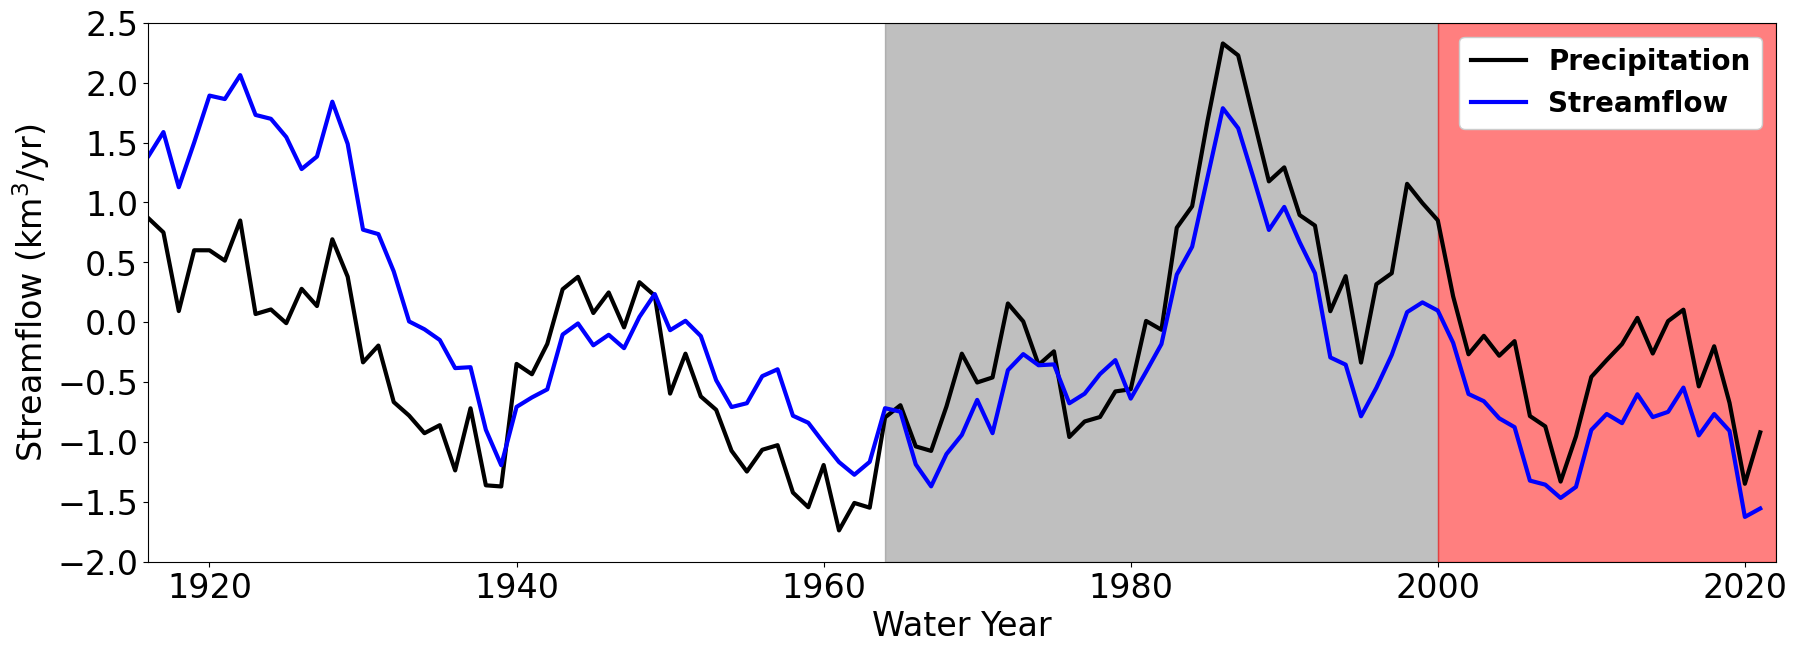

In [59]:
streamflow_vector = ucrb_naturalized_streamflow_tmp['annual_flow_km3'].loc[1906:2022].rolling(10,min_periods=2,).mean().values
precipitation_vector = annual_p_km3['p_km3'].loc[1906:2022].rolling({'WY':10},min_periods=2).mean().values
# normalize vectors
norm_anom_streamflow = (streamflow_vector-np.nanmean(streamflow_vector))/np.nanstd(streamflow_vector)
norm_anom_precipitation = (precipitation_vector-np.nanmean(precipitation_vector))/np.nanstd(precipitation_vector)
plt.figure(figsize=(21,7))
plt.plot(np.arange(1905,2022,1),norm_anom_precipitation, label='Precipitation', lw=3, color='k')
plt.plot(np.arange(1905,2022,1),norm_anom_streamflow, label='Streamflow', lw=3, color='b')
# shade baseline perid
plt.axvspan(1964, 2000, alpha=0.5, color='grey')
# shade Millennium Drought
plt.axvspan(2000, 2022, alpha=0.5, color='red')
plt.ylim(-2,2.5)
plt.xlim(1916, 2022)
plt.xlabel('Year')
plt.legend()
#increase y-axis tick label size
# make y-ticks everyy 
plt.yticks(size=24);
plt.xticks(size=24);
plt.legend(loc='upper right',
           framealpha=1, 
           ncols=1, 
           prop={'weight':'bold',
                 'size':20})

plt.ylabel('Normalized Anomaly', color='black', size=24)
plt.xlabel('Water Year', color='black', size=24)

### <a id='toc4_1_2_'></a>[Figure 1 A Plot within Manuscript](#toc0_)

In [16]:
# Function used for adding intervals to the plot
def add_interval(ax, xdata, ydata, color, caps="  "):
    line = ax.add_line(mpl.lines.Line2D(xdata, ydata, color=color, linewidth=3))
    anno_args = {
        'ha': 'center',
        'va': 'center',
        'size': 24,
        'color': line.get_color(),
    }
    a0 = ax.annotate(caps[0], xy=(xdata[0], ydata[0]), **anno_args)
    a1 = ax.annotate(caps[1], xy=(xdata[1], ydata[1]), **anno_args)
    return (line,(a0,a1))

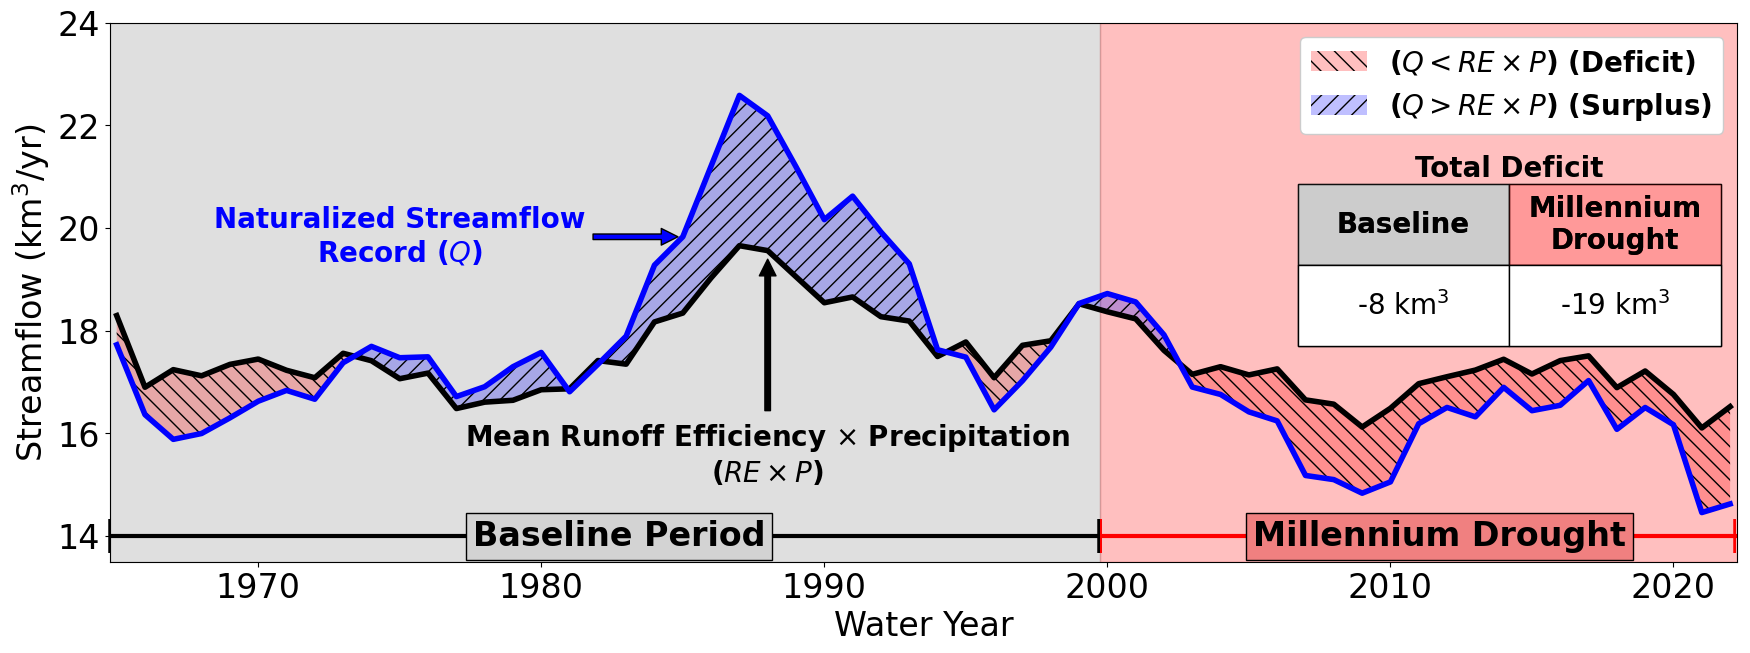

In [15]:
fig, ax = plt.subplots(figsize=(21,7))
runoff_ratio = 0.15*(annual_p_km3['p_km3'].sel(WY=slice(1964,2022)))
# plot line of P*runoff ratio
plt.plot(ucrb_naturalized_streamflow.loc[dt.date(1964,1,1):dt.date(2022,1,1)].index,
         runoff_ratio.rolling({'WY':10},min_periods=2).mean() , 
         color='k', 
         lw=4, 
         )
# plot naturalized streamflow
plt.plot(ucrb_naturalized_streamflow.loc[dt.date(1964,1,1):dt.date(2022,1,1)].index,
         ucrb_naturalized_streamflow_tmp['annual_flow_km3'].loc[1964:2022].rolling(10,min_periods=2,).mean(), 
         color='blue', 
         lw=4, 
         )

# hatch between two plots
plt.fill_between(ucrb_naturalized_streamflow.loc[dt.date(1964,1,1):dt.date(2022,1,1)].index,
                 runoff_ratio.rolling({'WY':10},min_periods=2).mean(),
                 ucrb_naturalized_streamflow_tmp['annual_flow_km3'].loc[1964:2022].rolling(10,min_periods=2,).mean(), 
                 where=runoff_ratio.rolling({'WY':10},min_periods=2).mean()>=ucrb_naturalized_streamflow_tmp['annual_flow_km3'].loc[1964:2022].rolling(10,min_periods=2,).mean(), 
                 facecolor='red', 
                 hatch='\\\\',
                 alpha=0.25, 
                 interpolate=True,
                 label=r'($Q < RE \times P$) (Deficit)')
plt.fill_between(ucrb_naturalized_streamflow.loc[dt.date(1964,1,1):dt.date(2022,1,1)].index,
                 runoff_ratio.rolling({'WY':10},min_periods=2).mean() ,
                 ucrb_naturalized_streamflow_tmp['annual_flow_km3'].loc[1964:2022].rolling(10,min_periods=2,).mean(), 
                 where=runoff_ratio.rolling({'WY':10},min_periods=2).mean()<ucrb_naturalized_streamflow_tmp['annual_flow_km3'].loc[1964:2022].rolling(10,min_periods=2,).mean(), 
                 facecolor='blue',
                 hatch='//', 
                 alpha=0.25, 
                 interpolate=True,
                 label=r'($Q > RE \times P$) (Surplus)')

# plt.ylim(runoff_ratio.rolling(10).mean().mean()-0.05,runoff_ratio.rolling(10).mean().mean()+0.05)
plt.axvspan(dt.date(1999,10,1),dt.date(2022,10,1),color='red',alpha=0.25,zorder=0)
# add a text box to label this span as the "Baseline Period"
plt.text(dt.date(2011,10,1), 14, 
        'Millennium Drought', 
        fontsize=24, 
        color='black', 
        ha='center', va='center', 
        fontweight='bold', 
        bbox={'facecolor':'lightcoral', 'pad':5})
# draw a horizontal line between the start and end of the baseline period
add_interval(ax,(dt.date(1999,10,1),dt.date(2022,3,1)),(14,14),'red', caps='||')
# add a text box to label this span as the "Baseline Period"
plt.text(dt.date(1982,10,1), 14, 
         'Baseline Period',
          fontsize=24, 
          color='black',
          backgroundcolor='lightgray', 
          ha='center', va='center',
          fontweight='bold', 
          bbox={'facecolor':'lightgray', 'pad':5})
# draw a horizontal line between the start and end of the baseline period
add_interval(ax,(dt.date(1964,10,1),dt.date(1999,9,1)),(14,14),'black', caps='||')
plt.axvspan(dt.date(1964,10,1),dt.date(1999,10,1),color='grey',alpha=0.25, zorder=0)

# add a horizontal line at the minimum of streaflow during the baseline period
diff_baseline = (runoff_ratio.rolling({'WY':10},min_periods=2).mean() - ucrb_naturalized_streamflow_tmp['annual_flow_km3'].loc[1964:2022].rolling(10,min_periods=2,).mean()).sel(WY=slice(1964,1999))
total_diff_baseline = diff_baseline.where(diff_baseline>0).sum()
total_surplus_baseline= diff_baseline.where(diff_baseline<0).sum()
        
# add a horizontal line at the minimum of streamflow during the Millennium Drought
diff_md = (runoff_ratio.rolling({'WY':10},min_periods=2).mean() - ucrb_naturalized_streamflow_tmp['annual_flow_km3'].loc[1964:2022].rolling(10,min_periods=2,).mean()).sel(WY=slice(2000,2022))   
total_diff_md = diff_md.where(diff_md>0).sum()
total_surplus_md= diff_md.where(diff_md<0).sum()

######## Table Formatting ########
col_labels=['Baseline','Millennium\nDrought']
row_labels=['Total Deficit']#,'Total Surplus']
table_vals=[[
            '{:.0f} km$^3$'.format(-total_diff_baseline),
            '{:.0f} km$^3$'.format(-total_diff_md)],
            ]#[
        #     '{:.0f} km$^3$'.format(-total_surplus_baseline),
        #     '{:.0f} km$^3$'.format(-total_surplus_md)
        #     ]]
# hidden table to help with transparency
hidden_table = plt.table(cellText=table_vals,
                  colWidths = [0.1]*2,
                #   rowLabels=row_labels,
                  colLabels=col_labels,
                  bbox=[0.73, 0.4, 0.26, 0.3],
                  cellLoc='center',
                  rowLoc='center')

# bold the column and row labels
for (row, col), cell in hidden_table.get_celld().items():
  if (row == 0) or (col == -1):
    cell.set_text_props(fontproperties=FontProperties(weight='bold'))
hidden_table.auto_set_font_size(False)
hidden_table.set_fontsize(20)
hidden_table.scale(1.5, 4.2)
# table with data
the_table = plt.table(cellText=table_vals,
                  colWidths = [0.1]*2,
                #   rowLabels=row_labels,
                  colLabels=col_labels,
                  bbox=[0.73, 0.4, 0.26, 0.3],
                  cellLoc='center',
                  rowLoc='center',
                  colColours=['grey','red'])
# bold the column and row labels
for (row, col), cell in the_table.get_celld().items():
  if (row == 0) or (col == -1):
    cell.set_text_props(fontproperties=FontProperties(weight='bold'))
    cell.set_alpha(0.4)
the_table.auto_set_font_size(False)
the_table.set_fontsize(20)
the_table.scale(1.5, 4.2)
# add title as text above table
plt.text((0.73+.99)/2, 0.73, 'Total Deficit',
        fontsize=20, color='black',
        fontweight='bold',
        ha='center', va='center',
        transform=ax.transAxes)

# add an arrow and point to mean runoff efficiency line
plt.annotate(r'Mean Runoff Efficiency $\times$ Precipitation'+'\n'+r'($RE \times P$)',
                xy=(dt.date(1988,1,1),runoff_ratio.rolling({'WY':10},min_periods=2).mean().sel(WY=1988).values),
                xytext=(dt.date(1988,1,1),runoff_ratio.rolling({'WY':10},min_periods=2).mean().sel(WY=1988).values-4.5),
                # center text
                ha='center',
                # increase text size
                size=20,
                # bold text
                weight='bold',
                # set arrow properties
                arrowprops=dict(facecolor='black', shrink=0.05),
                )
# add an arrow and point to mean runoff efficiency line
plt.annotate('Naturalized Streamflow\nRecord '+r'($Q$)',
                xy=(dt.date(1985,1,1),ucrb_naturalized_streamflow_tmp['annual_flow_km3'].loc[1964:2022].rolling(10,min_periods=2,).mean().loc[1985]),
                xytext=(dt.date(1975,1,1),ucrb_naturalized_streamflow_tmp['annual_flow_km3'].loc[1964:2022].rolling(10,min_periods=2,).mean().loc[1985]),
                # center text
                ha='center',
                va='center',
                # increase text size
                size=20,
                # bold text
                weight='bold',
                color='blue',
                # set arrow properties
                arrowprops=dict(facecolor='blue', shrink=0.05),
                )
                  
plt.xlim(dt.date(1964,10,1),dt.date(2022,4,1))
#increase y-axis tick label size
plt.yticks(size=24);
plt.xticks(size=24);
plt.legend(loc='upper right',
           framealpha=1, 
           ncols=1, 
           prop={'weight':'bold',
                 'size':20})
plt.ylim(13.5,24)
plt.ylabel('Streamflow (km$^3$/yr)', color='black', size=24)
plt.xlabel('Water Year', color='black', size=24)
# add title saying "15-year Rolling Mean UCRB Runoff Ratio"
# plt.title('UCRB Naturalized Streamflow and Runoff Efficiency * Precipitation\n10-year Rolling Mean', size=16)
# save figure at 700 dpi and 9x6 centimeters
fig.savefig('../figures/precip_deficit_streamflow_deficit.png', dpi=700, pad_inches=0.1)

### <a id='toc4_1_3_'></a>[Streamflow, Precipitation, Temperature Figure used in Supplemental Text](#toc0_)

<>:90: SyntaxWarning: invalid escape sequence '\d'
<>:90: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_9807/1304787421.py:90: SyntaxWarning: invalid escape sequence '\d'
  ax.set_ylabel('Temperature Anomaly,\n$\degree$C', size=12)


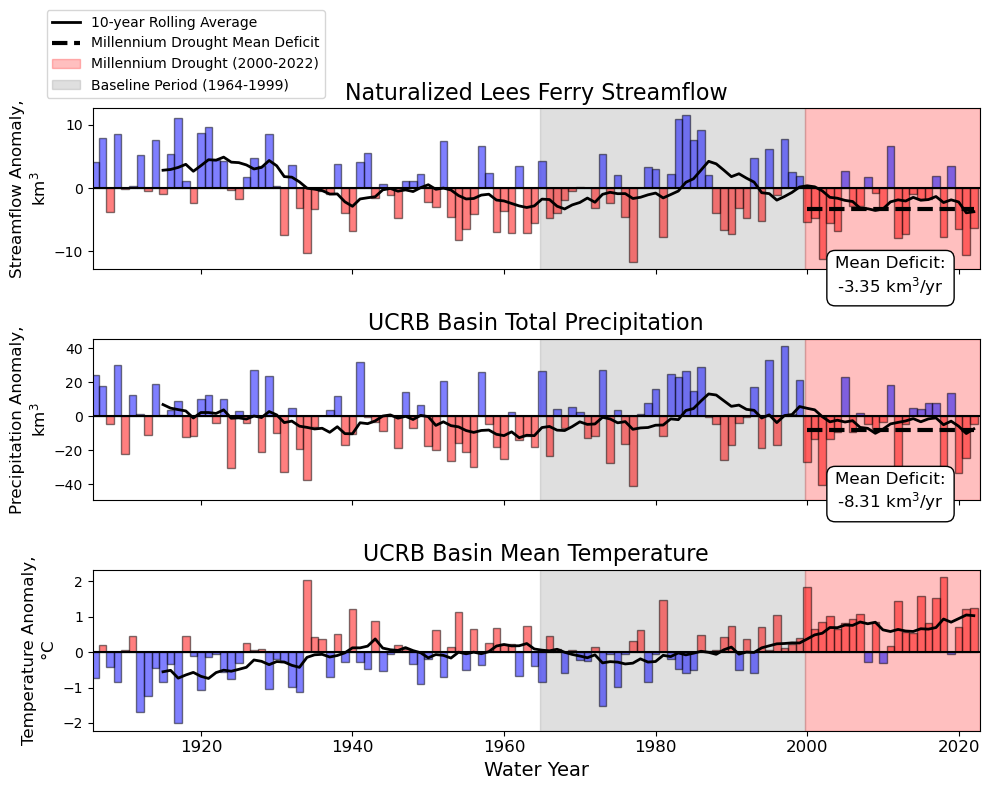

In [17]:
plt.style.use('default')
all_dates = pd.date_range('1895-10-01','2022-10-01', freq='1Y')
fig, axs = plt.subplots(nrows=3, figsize=(10,8), tight_layout=True, sharex=True)

ax = axs[0]
flow_anomaly = ucrb_naturalized_streamflow['annual_flow_km3']-ucrb_naturalized_streamflow['annual_flow_km3'].loc[dt.date(1963,1,1):dt.date(1999,1,1)].mean()
# create a linear regression for the flow_anomaly
slope1, intercept1, _,_,_ = stats.linregress(flow_anomaly.index.year,flow_anomaly.values)
# add bar plot of ucrb_naturalized_streamflow[annual_flow_km3]
ax.bar(flow_anomaly[flow_anomaly>=0].index, flow_anomaly[flow_anomaly>=0], width=365.25, color='blue',ec='k', alpha=0.5)
ax.bar(flow_anomaly[flow_anomaly<0].index, flow_anomaly[flow_anomaly<0], width=365.25, color='red',ec='k', alpha=0.5)
# add a 10 year moving average line to the plot
ax.plot(flow_anomaly.index, flow_anomaly.rolling(10).mean(), color='k', linewidth=2, label='10-year Rolling Average')
# add a trend line to the plot
# ax.plot(flow_anomaly.index , slope1*flow_anomaly.index.year + intercept1, ls='--',color='k', label='Best Fit Line', lw=2)

# runoff_ratio = ucrb_naturalized_streamflow_tmp['annual_flow_km3']/annual_p_km3['p_km3'].sel(WY=slice(1906,2022))

# ax3.plot(ucrb_naturalized_streamflow.index,runoff_ratio.rolling(10).mean(), color='k', lw=2, ls='dotted')
# ax3.set_ylabel('Runoff Ratio', color='black', size=12)
# ax3.set_ylim(runoff_ratio.rolling(10).mean().mean()-0.05,runoff_ratio.rolling(10).mean().mean()+0.05)
# # set ax3 y-ticks to be rounded to 2 decimal places
# ax3.set_yticklabels([f"{i:.2f}" for i in ax3.get_yticks()])
# ax3.tick_params(axis='y', labelcolor='black', labelsize=12)
# add a horizontal line for the mean flow anomaly from 2000-2022 spanning the years 2000-2022
ax.plot([dt.date(2000,1,1), dt.date(2022,1,1)],
        [flow_anomaly.loc[dt.date(2000,1,1):dt.date(2022,1,1)].mean(),flow_anomaly.loc[dt.date(2000,1,1):dt.date(2022,1,1)].mean()],
        color='k', ls='--', lw=3, label='Millennium Drought Mean Deficit')
# add a text box for the value of the flow anomaly from 2000-2022
ax.text(dt.date(2011,1,1), -14,
        f"Mean Deficit:\n{flow_anomaly.loc[dt.date(2000,1,1):dt.date(2022,1,1)].mean():.2f} km$^3$/yr", size=12,
        verticalalignment='center', horizontalalignment='center',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# add a 0 line
ax.axhline(0, color='k')
# set the labels
ax.set_ylabel('Streamflow Anomaly,\nkm$^3$', size=12)
ax.set_title('Naturalized Lees Ferry Streamflow', size=16)
ax.set_xlim()

# plot precipitation
ax = axs[1]
precip_anomaly = (annual_p_km3['p_km3'].sel(WY=slice(1906,2022))-annual_p_km3['p_km3'].sel(WY=slice(1963,1999)).mean()).to_pandas()
precip_anomaly_with_dates = precip_anomaly.copy()
precip_anomaly_with_dates.index = all_dates[10:]
# create a linear regression for the precip_anomaly
slope2, intercept2, _,_,_ = stats.linregress(precip_anomaly.index,precip_anomaly)

# add bar plot of ucrb_naturalized_streamflow[annual_flow_km3]
ax.bar(precip_anomaly_with_dates[precip_anomaly_with_dates>=0].index, precip_anomaly[precip_anomaly>=0], width=365.25, color='blue',ec='k', alpha=0.5)
ax.bar(precip_anomaly_with_dates[precip_anomaly_with_dates<0].index, precip_anomaly[precip_anomaly<0], width=365.25, color='red',ec='k', alpha=0.5)
# add a 10 year moving average line to the plot
ax.plot(all_dates[10:], precip_anomaly.rolling(10).mean(), color='k', linewidth=2, label='10-year Rolling Average')
# add a trend line to the plot
# ax.plot(all_dates[10:], slope2*precip_anomaly.index + intercept2, ls='--',color='k', label='Best Fit Line', lw=2)
# add a horizontal line for the mean flow anomaly from 2000-2022 spanning the years 2000-2022
ax.plot([dt.date(2000,1,1), dt.date(2022,1,1)],
        [precip_anomaly.loc[2000:2022].mean(),precip_anomaly.loc[2000:2022].mean()],
        color='k', ls='--', lw=3, label='Millennium Drought Mean Deficit')
# add a text box for the value of the flow anomaly from 2000-2022
ax.text(dt.date(2011,1,1), -45,
        f"Mean Deficit:\n{precip_anomaly.loc[2000:2022].mean():.2f} km$^3$/yr", size=12,
        verticalalignment='center', horizontalalignment='center',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
# add a 0 line
ax.axhline(0, color='k')
# set the labels
ax.set_ylabel('Precipitation Anomaly,\nkm$^3$', size=12)
ax.set_title('UCRB Basin Total Precipitation',size=16)

# plot temperature
ax = axs[2]
temp_anomaly = (annual_t_mean['t_mean'].sel(WY=slice(1906,2022))-annual_t_mean['t_mean'].sel(WY=slice(1963,1999)).mean()).to_pandas()
temp_anomaly_with_dates = temp_anomaly.copy()
temp_anomaly_with_dates.index = all_dates[10:]
# create a linear regression for the temp_anomaly
slope3, intercept3, _,_,_ = stats.linregress(temp_anomaly.index,temp_anomaly)

# add bar plot of temp_anomaly
ax.bar(temp_anomaly_with_dates[temp_anomaly_with_dates>=0].index, temp_anomaly[temp_anomaly>=0], width=365.25, color='red',ec='k', alpha=0.5)
ax.bar(temp_anomaly_with_dates[temp_anomaly_with_dates<0].index, temp_anomaly[temp_anomaly<0], width=365.25, color='blue',ec='k', alpha=0.5)
# add a 10 year moving average line to the plot
ax.plot(all_dates[10:], temp_anomaly.rolling(10).mean(), color='k', linewidth=2, label='10-year Rolling Average')
# add a trend line to the plot
# ax.plot(all_dates[10:], slope3*temp_anomaly.index + intercept3, ls='--',color='k', label='Best Fit Line', lw=2)
# add a 0 line
ax.axhline(0, color='k')
# set the labels
ax.set_ylabel('Temperature Anomaly,\n$\degree$C', size=12)
ax.set_title('UCRB Basin Mean Temperature', size=16)
ax.set_xlabel('Water Year', size=14)
# increase the size of the x-axis tick labels
ax.tick_params(axis='x', which='major', labelsize=12)
for ax in axs:
    ax.axvspan(dt.date(1999,10,1),dt.date(2022,10,1),color='red',alpha=0.25, label='Millennium Drought (2000-2022)',zorder=0)
    ax.axvspan(dt.date(1964,10,1),dt.date(1999,10,1),color='grey',alpha=0.25, label='Baseline Period (1964-1999)',zorder=0)
    ax.set_xlim(dt.date(1905,10,1),dt.date(2022,10,1))
    
    # create a new legend for the vertical lines
    ax2 = ax.twinx()
    # add a vertical line at 2000 and label start of millennium drought
#     ax2.axvline(dt.date(1999,10,1), color='magenta', ls='--', lw=2, label='Millennium Drought Onset')
    # add a vertical line at 1962 and label Lake Powell filling
#     ax2.axvline(dt.date(1964,10,1), color='magenta', ls=':', lw=2,  label='Lake Powell Filling')
    # add a vertical line at 1922 and label Colorado River Compact
#     ax2.axvline(dt.date(1922,10,1), color='magenta', ls='-.', lw=2,  label='Colorado River Compact')
    ax2.axis('off')
    
    if ax == axs[0]:
        ax.legend(bbox_to_anchor=(-0.06, 1.02, 1, 0.2), loc="lower left",)  
        # ax2.legend(bbox_to_anchor=(1, 1.02), loc="lower right",)

# <a id='toc5_'></a>[Let's change to focusing on our HCDN basins](#toc0_)

Pull in the HCDN basins as a geodataframe

In [163]:
hcdn_basins = gpd.read_file('../data/geodata/basin_station_sntl.json')
hcdn_basins = hcdn_basins.set_index('gage')
# these two basins are especially difficult since they are small and extremely flashy and ephemeral. the last basin ended its record in the early 2000s
bad_gages = hcdn_basins.index.isin(['09306242','09378170','09378630']) 
hcdn_basins = hcdn_basins[~bad_gages]


Create a data array to add in the basin area to our dataset

In [164]:
area_da = hcdn_basins.basin_area.to_xarray()
area_da = area_da.rename({'gage':'site_no'})

Create a data array to add in centroid lat and long to our dataset

In [165]:
x_vals = hcdn_basins.geometry.centroid.x.to_xarray()
x_vals.name = 'x'
y_vals = hcdn_basins.geometry.centroid.y.to_xarray()
y_vals.name = 'y'
coords_da =  xr.merge([x_vals,y_vals])
coords_da = coords_da.rename({'gage':'site_no'})


/tmp/ipykernel_3255/4223117852.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  x_vals = hcdn_basins.geometry.centroid.x.to_xarray()
/tmp/ipykernel_3255/4223117852.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  y_vals = hcdn_basins.geometry.centroid.y.to_xarray()


Open the UCRB dem and derive basin mean elevations for each basin...

In [166]:
ucrb_dem = rxr.open_rasterio('../geodata/ucrb_dem_150m.tif')
basin_mean_elevations = {}
for gage in hcdn_basins.index:
    basin = hcdn_basins[hcdn_basins.index==gage]
    clipped_dem = ucrb_dem.rio.clip(basin.geometry).squeeze()
    clipped_dem_ma = clipped_dem.where(clipped_dem>0)
    basin_mean_elevations[gage] = clipped_dem_ma.mean().values

Then add this to a data array to pull into our entire dataset

In [202]:
elevation_da = xr.Dataset(basin_mean_elevations).to_array()
elevation_da.name='elevation'
elevation_da = elevation_da.rename({'variable':'site_no'})

Derive basin elevation ranges

In [203]:
basin_elevation_range = {}
for gage in hcdn_basins.index:
    basin = hcdn_basins[hcdn_basins.index==gage]
    clipped_dem = ucrb_dem.rio.clip(basin.geometry).squeeze()
    clipped_dem_ma = clipped_dem.where(clipped_dem>0)
    basin_elevation_range[gage] = clipped_dem_ma.max().values - clipped_dem_ma.min().values 

Then add this to a data array to pull into our entire dataset

In [204]:
elevation_range_da = xr.Dataset(basin_elevation_range).to_array()
elevation_range_da.name='elevation_range'
elevation_range_da = elevation_range_da.rename({'variable':'site_no'})

Add precipitation

In [205]:
# Pull in HCDN precip data
hcdn_prism_seasonal_ppt = xr.open_dataset('../data/precipdata/prism_hcdn_seasonal_ppt_14710.nc')
hcdn_prism_seasonal_ppt = hcdn_prism_seasonal_ppt.sel(dim_1='ppt')
hcdn_prism_seasonal_ppt = hcdn_prism_seasonal_ppt.rename({'__xarray_dataarray_variable__':'ppt','variable':'site_no'})

hcdn_prism_seasonal_ppt['year'] = hcdn_prism_seasonal_ppt.month.dt.year.where(hcdn_prism_seasonal_ppt.month.dt.month<10, hcdn_prism_seasonal_ppt.month.dt.year+1)
hcdn_prism_annual_ppt = hcdn_prism_seasonal_ppt.groupby('year').sum()

Pull in our HCDN flow data and convert to mm per day units

In [208]:
# Pull in streamflow data and merge in new datarrays
hcdn_streamflow_daily_ds = xr.open_dataset('../data/streamflowdata/hcdn_daily_q.nc')
hcdn_streamflow_daily_ds['site_no'] = ['0'+str(site) for site in hcdn_streamflow_daily_ds['site_no'].values]

hcdn_streamflow_daily_ds = hcdn_streamflow_daily_ds.merge(area_da)
hcdn_streamflow_daily_ds = hcdn_streamflow_daily_ds.merge(elevation_da)
hcdn_streamflow_daily_ds = hcdn_streamflow_daily_ds.merge(elevation_range_da)
hcdn_streamflow_daily_ds = hcdn_streamflow_daily_ds.merge(coords_da)
# Calculate flow rates in terms of basin-normalized mm/day from cubic meters per day
hcdn_streamflow_daily_ds['q_mm_day'] = hcdn_streamflow_daily_ds['00060_Mean'] * 1000 / hcdn_streamflow_daily_ds.basin_area
# Drop bad basins
hcdn_streamflow_daily_ds = hcdn_streamflow_daily_ds.where(~hcdn_streamflow_daily_ds.site_no.isin(['09306242','09378170','09378630']),drop=True)

# Add water year back in 
hcdn_streamflow_daily_ds = hcdn_streamflow_daily_ds.drop('WY')
wy_da = hcdn_streamflow_daily_ds.date.dt.year.where(hcdn_streamflow_daily_ds.date.dt.month<10, hcdn_streamflow_daily_ds.date.dt.year+1)
wy_da.name = 'WY'
hcdn_streamflow_daily_ds = hcdn_streamflow_daily_ds.merge(wy_da)

# Derive summer only mean flows 
hcdn_q_summer_ds = hcdn_streamflow_daily_ds.where(hcdn_streamflow_daily_ds.date.dt.month.isin([7,8,9])).to_dataframe().dropna().to_xarray()
hcdn_q_summer_ds = hcdn_q_summer_ds.sortby('date')
hcdn_q_summer_ds = hcdn_q_summer_ds.where(hcdn_q_summer_ds['q_mm_day']>0)
hcdn_q_summer_ds = hcdn_q_summer_ds.rename({'q_mm_day':'q_mm_day_summer'})
hcdn_q_summer_mean_ds = hcdn_q_summer_ds.groupby('date.year').mean().where(hcdn_q_summer_ds['00060_Mean'].groupby('date.year').count()>85)

# Derive the mean Spring + Summer flow for AMJJAS
hcdn_q_spring_summer_ds = hcdn_streamflow_daily_ds.where(hcdn_streamflow_daily_ds.date.dt.month.isin([4,5,6,7,8,9])).to_dataframe().dropna().to_xarray()
hcdn_q_spring_summer_ds = hcdn_q_spring_summer_ds.sortby('date')
hcdn_q_spring_summer_ds = hcdn_q_spring_summer_ds.where(hcdn_q_spring_summer_ds['q_mm_day']>0)
# Groupby year but filter out years with less than 173 days of streamflow data
hcdn_q_spring_summer_mean_ds = hcdn_q_spring_summer_ds.groupby('date.year').mean().where(hcdn_q_spring_summer_ds['00060_Mean'].groupby('date.year').count()>173)
hcdn_q_spring_summer_mean_ds = hcdn_q_spring_summer_mean_ds.merge(hcdn_prism_annual_ppt).squeeze()
hcdn_q_spring_summer_mean_ds = hcdn_q_spring_summer_mean_ds.where(~hcdn_q_spring_summer_mean_ds.site_no.isin(['09306242','09378170','09378630']),drop=True)
hcdn_q_spring_summer_mean_ds = hcdn_q_spring_summer_mean_ds.merge(hcdn_q_summer_mean_ds['q_mm_day_summer'])
hcdn_q_spring_summer_mean_ds['q_mm'] = hcdn_q_spring_summer_mean_ds['q_mm_day']*183 # total q in mm over the period
# Normalize these values for basin-to-basin comparison
hcdn_q_spring_summer_norm = (hcdn_q_spring_summer_mean_ds-hcdn_q_spring_summer_mean_ds.mean(dim='year'))/hcdn_q_spring_summer_mean_ds.std(dim='year')

# Save new daily dataset 
# hcdn_streamflow_daily_ds.to_netcdf('../data/streamflowdata/hcdn_basin_chars_and_daily_q.nc')

In [252]:
# add precip to annual flows
hcdn_streamflow_ds = hcdn_streamflow_daily_ds.groupby(hcdn_streamflow_daily_ds.WY).mean().where(hcdn_streamflow_daily_ds['00060_Mean'].groupby(hcdn_streamflow_daily_ds.WY).count()>350)
hcdn_streamflow_ds = hcdn_streamflow_ds.merge(hcdn_prism_annual_ppt).squeeze()
hcdn_streamflow_ds = hcdn_streamflow_ds.where(~hcdn_streamflow_ds.site_no.isin(['09306242','09378170','09378630']),drop=True).drop_dims(['year'])
# establish q_mm by multiplying by the count of valid data for each water year
hcdn_streamflow_ds['q_mm'] = hcdn_streamflow_ds['q_mm_day']*hcdn_streamflow_daily_ds['00060_Mean'].groupby(hcdn_streamflow_daily_ds.WY).count()
# save to netcdf
# hcdn_streamflow_ds.to_netcdf('../data/streamflowdata/hcdn_basin_annual_q.nc')

Create a simple plot of basin-to-basin correlation of spring+summer mean streamflow

<AxesSubplot: xlabel='site_no', ylabel='site_no'>

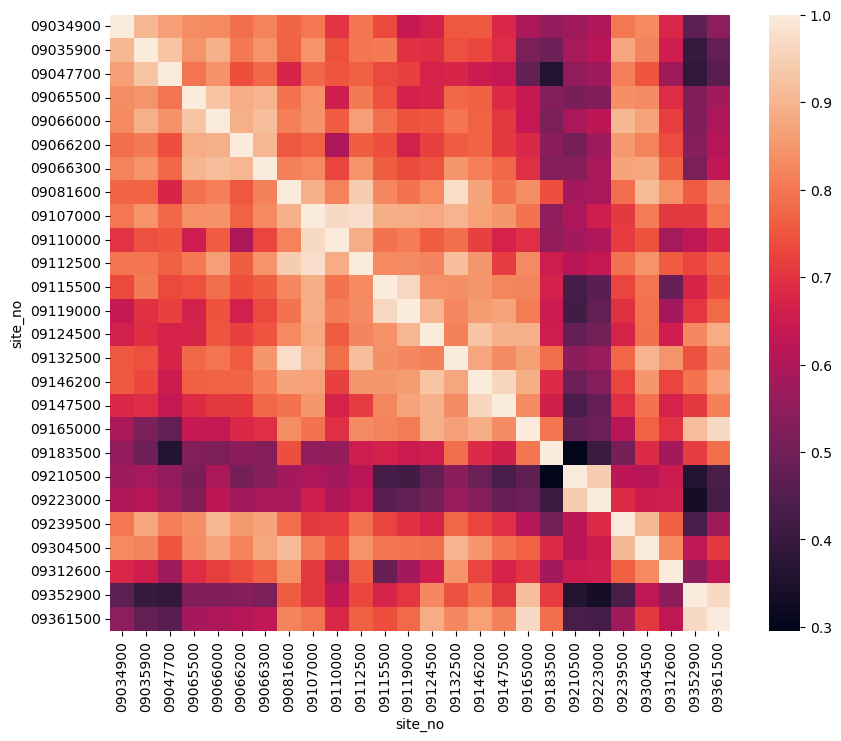

In [39]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(hcdn_q_spring_summer_mean_ds['00060_Mean'].to_pandas().corr(), ax=ax)

Plot basin mean elevation against mean $Q_{SpSu}$ 

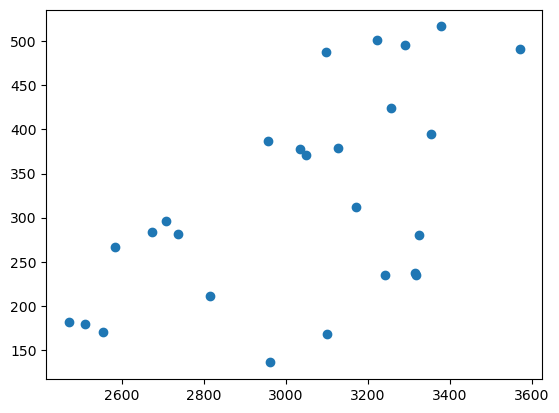

In [244]:
# drop years where streamflow is in the bottom 10% of all years at each site
hcdn_streamflow_ds_filtered = hcdn_streamflow_ds.where((hcdn_streamflow_ds['q_mm'] > hcdn_streamflow_ds['q_mm'].quantile(0.10)) & 
                                                (hcdn_streamflow_ds['q_mm'] < hcdn_streamflow_ds['q_mm'].quantile(0.90)), drop=True)
hcdn_streamflow_ds_mean = hcdn_streamflow_ds_filtered.mean(dim='WY')
plt.scatter(hcdn_streamflow_ds_mean.elevation, hcdn_streamflow_ds_mean['q_mm'])                                                                      

In [ ]:
df = pd.DataFrame({'elevation':hcdn_streamflow_ds_mean.elevation.to_pandas(), 'q_mm':hcdn_streamflow_ds_mean['q_mm'].to_pandas()})


# Define the bins and labels for elevation groups
labels = [1,0,2]  # The labels for each bin

# Use pd.cut() to categorize elevation and create a new column
df['elevation_group'] = pd.cut(df['elevation'], bins=3, labels=labels, right=False)



Text(0.5, 1.0, 'Do high elevation basins have highest RR?')

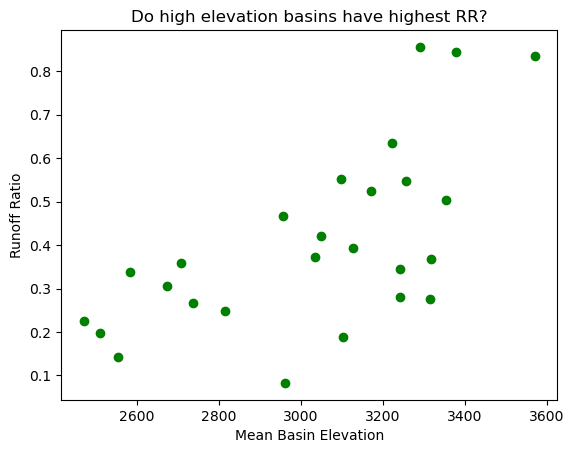

In [36]:
fig, ax = plt.subplots()
for site in hcdn_q_spring_summer_mean_ds.site_no:
    ax.scatter(hcdn_q_spring_summer_mean_ds['elevation'].sel(site_no=site).max().values,
                hcdn_q_spring_summer_mean_ds['q_mm'].sel(site_no=site).mean().values/hcdn_q_spring_summer_mean_ds['ppt'].sel(site_no=site).mean().values,
               color='green',
               )

ax.set_xlabel('Mean Basin Elevation')
ax.set_ylabel('Runoff Ratio')
ax.set_title('Do high elevation basins have highest RR?')

Text(0.5, 1.0, 'Do high elevation basins have highest Q$_{SpSu}$?')

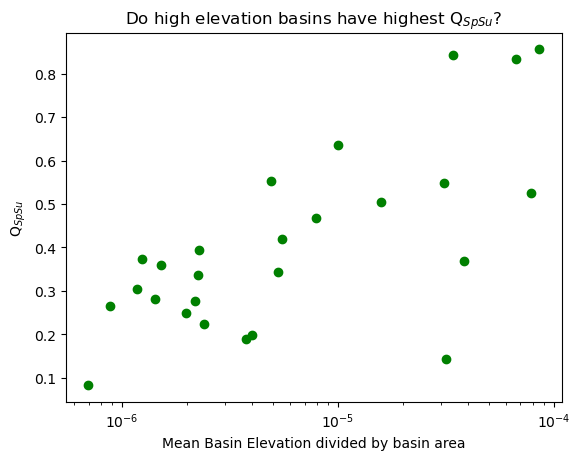

In [37]:
fig, ax = plt.subplots()

ax.scatter(hcdn_q_spring_summer_mean_ds['elevation_range'].mean(dim='year').values/hcdn_q_spring_summer_mean_ds['basin_area'].mean(dim='year').values,
           hcdn_q_spring_summer_mean_ds['q_mm'].mean(dim='year').values/hcdn_q_spring_summer_mean_ds['ppt'].mean(dim='year').values,
           color='green',
           )
ax.set_xscale('log')
ax.set_xlabel('Mean Basin Elevation divided by basin area')
ax.set_ylabel('Q$_{SpSu}$')
ax.set_title('Do high elevation basins have highest Q$_{SpSu}$?')

# <a id='toc6_'></a>[Cumulative Streamflow Deficit Plots](#toc0_)

In [186]:
rolling_windows = np.arange(1,21,1)
rolling_vals = {}
min_start_year = []
for window in rolling_windows:
    rolling_vals[window] = ucrb_naturalized_streamflow['annual_flow_km3'].rolling(window, center=False).mean()
    min_start_year.append(rolling_vals[window].idxmin() - window)

(3.0, 30.0)

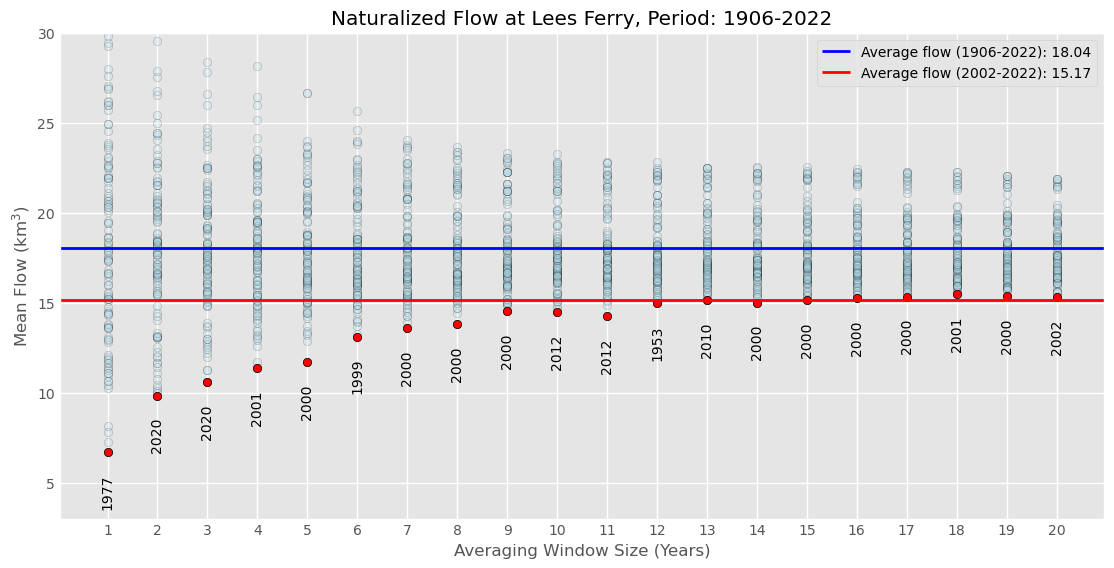

In [187]:
rolling_q_df = pd.DataFrame(rolling_vals)
plt.figure(figsize=(12,6))
for i,col in enumerate(rolling_q_df):
    plt.scatter(np.full(len(rolling_q_df.index),col), rolling_q_df[col], color='lightblue', alpha=0.2, ec='k')
    plt.scatter(col, rolling_q_df.loc[min_start_year[i]+col,col], color='red', ec='k')
    plt.text(x=col, 
            y=rolling_q_df.loc[min_start_year[i]+col,col]-3, 
            s=min_start_year[i]+1,
            rotation='vertical',
            horizontalalignment='center')
plt.axhline(ucrb_naturalized_streamflow['annual_flow_km3'].mean(), color='blue',lw=2,
            label=f"Average flow (1906-2022): {round(ucrb_naturalized_streamflow['annual_flow_km3'].mean(),2)}")
plt.axhline(ucrb_naturalized_streamflow.loc[2002:2022,'annual_flow_km3'].mean(), color='red',lw=2,
            label=f"Average flow (2002-2022): {round(ucrb_naturalized_streamflow.loc[2002:2022,'annual_flow_km3'].mean(),2)}")
plt.title('Naturalized Flow at Lees Ferry, Period: 1906-2022')
plt.ylabel('Mean Flow (km$^3$)')
plt.xlabel('Averaging Window Size (Years)')
plt.legend()
plt.xticks(rolling_windows);
plt.ylim(3,30)

In [203]:
def cumulativeDeparture(df):
    return (df - ucrb_naturalized_streamflow['annual_flow_km3'].mean()).sum()


In [207]:
rolling_windows_sum = np.arange(1,21,1)
rolling_vals_sum = {}
max_start_year_sum = []
for window in rolling_windows:
    rolling_vals_sum[window] = ucrb_naturalized_streamflow['annual_flow_km3'].rolling(window, center=False).apply(lambda x: cumulativeDeparture(x))
    max_start_year_sum.append(rolling_vals_sum[window].idxmin() - window)

(-60.0, 0.0)

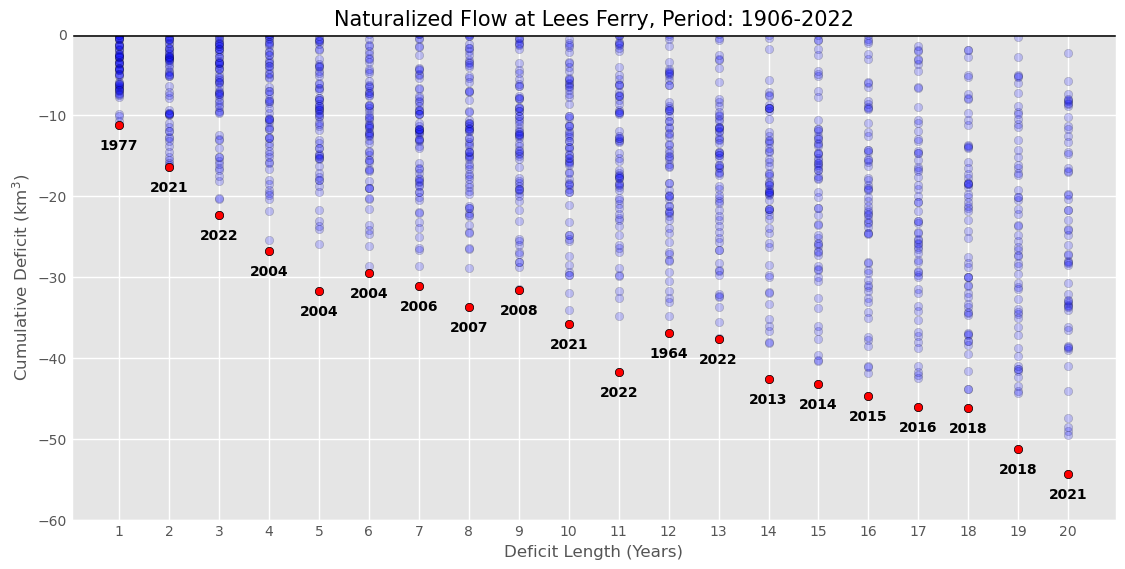

In [210]:
rolling_q_sum_df = pd.DataFrame(rolling_vals_sum)
plt.figure(figsize=(12,6))
plt.axhline(0, color='k',lw=4)
for i,col in enumerate(rolling_q_sum_df):
    plt.scatter(np.full(len(rolling_q_sum_df.index),col), rolling_q_sum_df[col], color='blue', alpha=0.2, ec='k')
    plt.scatter(col, rolling_q_sum_df.loc[max_start_year_sum[i]+col,col], color='red', ec='k')
    plt.text(x=col, 
             y=rolling_q_sum_df.loc[max_start_year_sum[i]+col,col]-3, 
             s=max_start_year_sum[i]+i+1,
             rotation='horizontal',
             horizontalalignment='center',
             # bold the text
             weight='bold')
plt.title('Naturalized Flow at Lees Ferry, Period: 1906-2022', size=15)
plt.ylabel('Cumulative Deficit (km$^3$)')
plt.xlabel('Deficit Length (Years)')
plt.xticks(rolling_windows_sum);
plt.ylim(0-60,0)

### <a id='toc6_1_1_'></a>[Quick Statistical test for a single site](#toc0_)

In [194]:
site = '09146200'
hcdn_annual_mean = xr.open_dataset('../data/streamflowdata/hcdn_basin_annual_q.nc')
single_site_pre = hcdn_annual_mean.sel(site_no=site)['q_mm'].to_pandas().dropna().loc[:1999]
single_site_post = hcdn_annual_mean.sel(site_no=site)['q_mm'].to_pandas().dropna().loc[2000:]

In [195]:
conf = 0.05
z_alpha = stats.norm.ppf(conf)
print("z_alpha = {}".format(z_alpha)) 

z_alpha = -1.6448536269514729


In [196]:
s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                   (single_site_post.std(ddof=1)**2)/len(single_site_post))
print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

Pooled standard deviation is 24.812191242855683 mm


In [197]:
# null hypothesis: no change in sample means
delta = 0*single_site_pre.mean()
# compute test statistic
z_test = ((single_site_post.mean()-single_site_pre.mean())-
          delta)/s_pooled
print("z-score = {}".format(np.round(z_test,2))) 

z-score = -1.5


p = 0.934


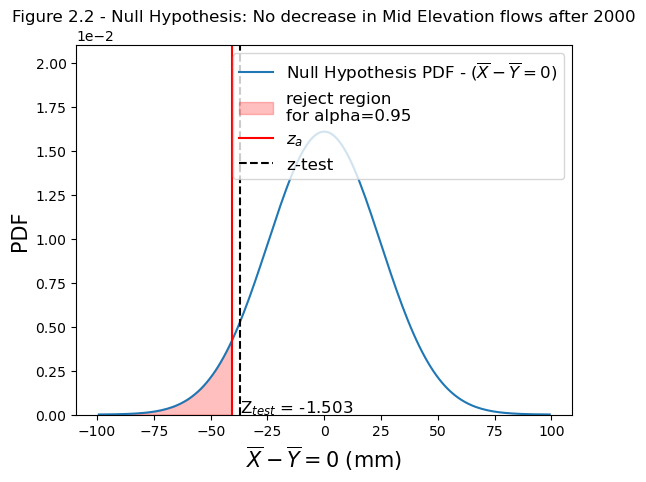

In [198]:
fig, ax = plt.subplots()

# Reference 1 - code adapted from Lab 2-1
# create null pdf
z = np.linspace(-4,4, num=160)*s_pooled
ax.plot(z, 
        stats.norm.pdf(z,delta,s_pooled), 
        label='Null Hypothesis PDF - ($\overline{X}-\overline{Y}=0$)') # 0 and 1 are mu and sigma

# # define alpha
alpha = 0.95
# # Plot the region that z_test would have to fall in in order for us to reject the null hypothesis
conf = 1-alpha
z_alpha = stats.norm.ppf(conf)
shade_region = np.linspace(np.min(z),z_alpha*s_pooled,10)
ax.fill_between(shade_region,
                stats.norm.pdf(shade_region,delta,s_pooled), 
                color='r', 
                alpha=0.25, 
                label='reject region\nfor alpha={}'.format(np.round(1-conf,2)))
# # Plot a line at 95% confidence interval
ax.axvline(z_alpha*s_pooled, 
            color='r', 
            label='$z_{a}$')

# # Plot a line at z_test
ax.axvline(z_test*s_pooled, 
            color='black', 
            linestyle='--', 
            label='z-test')
ax.text(z_test*s_pooled, 
         1.2e-4, 
         r'Z$_{test}$ = '+str(round(z_test,3)), 
         fontsize=12, 
         color='k')
# Add labels
ax.set_ylim((0,2.1e-2))
ax.set_xlabel('$\overline{X}-\overline{Y}=0$ (mm)', fontsize=15)
ax.set_ylabel('PDF', fontsize=15)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.legend(fontsize=12)
ax.set_title('Figure 2.2 - Null Hypothesis: No decrease in Mid Elevation flows after 2000')
# compute p value
pvalue = 1 - stats.norm.cdf(z_test)
print("p = {}".format(np.round(pvalue,3)))

In [221]:
def closest_value_groupby(df, column_name, target_value):
    # Calculate the absolute differences between each value in the column and the target value
    differences = np.abs(df[column_name] - target_value)
    
    # Find the index of the closest value
    closest_index = differences.idxmin()
    
    # Get the closest value
    closest_value = df.loc[closest_index, column_name]
    
    return closest_index.dayofyear


### <a id='toc6_1_2_'></a>[Double Mass Plots](#toc0_)

Trying to use these to show change in Q-Q plot during Millennium Drought

In [132]:
# Plot all points and trend-line
def plotBestFit2(df, var1, var2, ax, color):
    m,b,r = precipFlowLinReg(df[var1],
                            df[var2])
    x = [df[var1].min(),
        df[var1].max()]
    y = [df[var1].min()*m+b,
        df[var1].max()*m+b]
    ax.plot(x,y, color=color, lw=1)

def doubleMassPlot(ds1, ax, to_plot=True):
    df1 = ds1['q_mm'].to_pandas()
    df2 = (ucrb_naturalized_streamflow['annual_flow_km3'] * 1e12 /(ucrb_basin_boundary.area.values[0]))
    combined_df = pd.concat([df1,df2], axis=1).replace(0, np.nan).dropna()
    residuals = combined_df[0] - combined_df['annual_flow_km3']
    combined_df_cumsum = combined_df.cumsum()
    if to_plot:
        ax.scatter(combined_df_cumsum[0].loc[:2000].values, combined_df_cumsum['annual_flow_km3'].loc[:2000].values,
                color='white',
                ec='red')
        if len(combined_df_cumsum) > 2:
            plotBestFit2(combined_df_cumsum.loc[:2000], 
                    var1 = 0,
                    var2 = 'annual_flow_km3',
                    ax=ax,
                    color='red')
        ax.scatter(combined_df_cumsum[0].loc[2000:2022].values, combined_df_cumsum['annual_flow_km3'].loc[2000:2022].values,
                color='white',
                ec='blue')
        if len(combined_df_cumsum.loc[2000:2022]) > 2:
            plotBestFit2(combined_df_cumsum.loc[2000:2022], 
                    var1 = 0,
                    var2 = 'annual_flow_km3',
                    ax=ax,
                    color='blue')
    return residuals

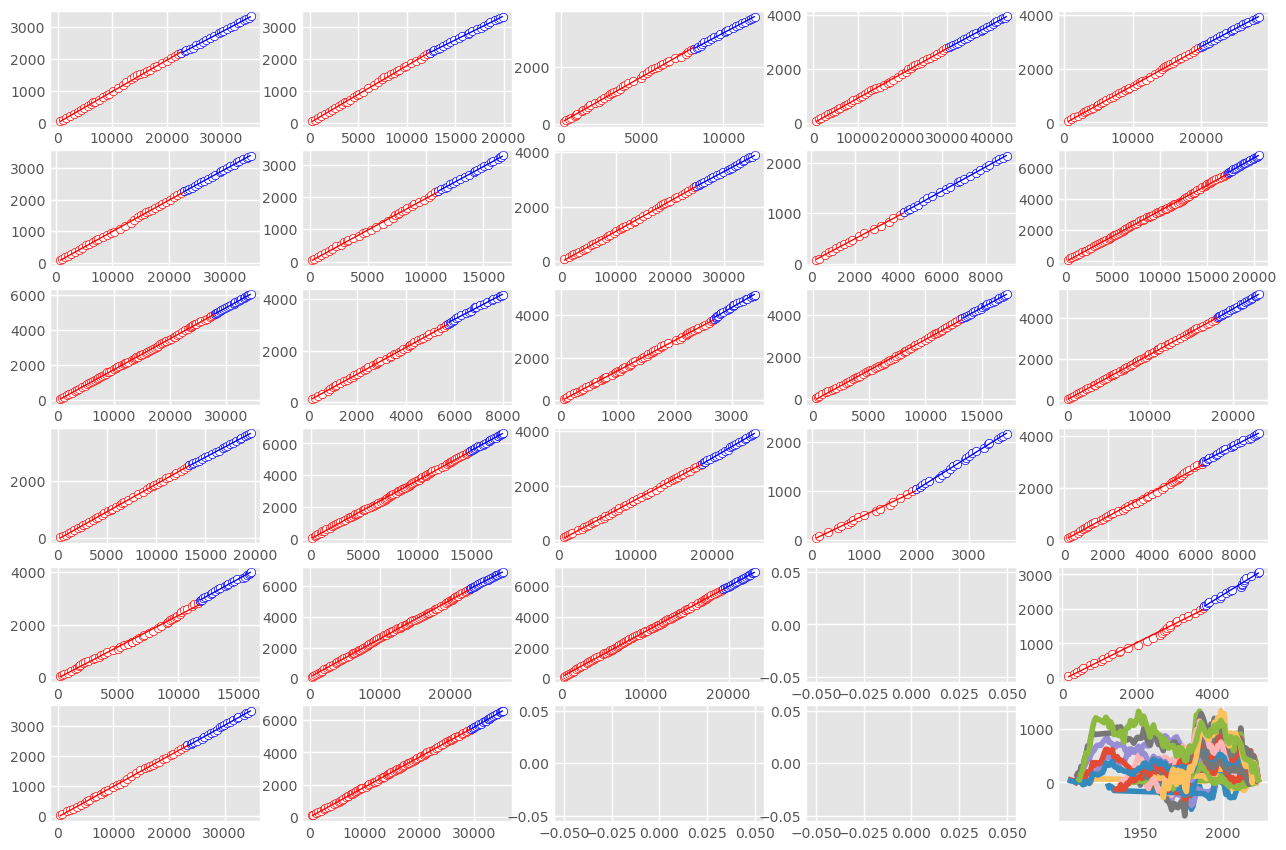

In [131]:
fig, axs = plt.subplots(6,5, figsize=(14,10))
axs = axs.ravel()
residuals = []
for i,site_no in enumerate(hcdn_q_spring_summer_mean_ds.site_no.values):
    residuals.append(doubleMassPlot(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no),ax=axs[i]))